# Classification Multimodale ajustée : Rakuten Challenge 2020
    
<img src="https://static.cnews.fr/sites/default/files/styles/image_640_360/public/datascientest_5fe203c15886e.jpg" alt="data" style="width: 600px;">

# Import des données et connexion au TPU

In [ ]:
import os, time, datetime, sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import random
import logging
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#Tensorflow
import tensorflow as tf

#Corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#warning
from warnings import filterwarnings
filterwarnings('ignore')

#Transformers
!pip install sentencepiece # a faire avant !! Sinon retourne une erreur lors de la tokenisation
!pip install transformers

path_cwd = os.getcwd()
logger = logging.getLogger(__name__)


print(os.getcwd())
print(sys.executable)
print(sys.version)
print(sys.version_info)

     |████████████████████████████████| 1.2 MB 5.5 MB/s 
     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 3.3 MB 57.1 MB/s 
     |████████████████████████████████| 895 kB 71.7 MB/s 
     |████████████████████████████████| 636 kB 73.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
/content
/usr/bin/python3
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()
project_id = 'cognitivpyshop'
!gcloud config set project {project_id}
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

Updated property [core/project].


In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.39.128.82:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.39.128.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.39.128.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))

Your runtime has 37.8 gigabytes of available RAM


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/CognitivPyShop/images_train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

with zipfile.ZipFile('/content/drive/MyDrive/CognitivPyShop/datasets.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

## Préparation des données 

In [ ]:
X_train = pd.read_csv('datasets/X_train.csv', index_col=0)
X_test = pd.read_csv('datasets/X_test.csv', index_col=0)
df_train = pd.read_csv('datasets/dataset_train.csv', index_col=0)
df_test = pd.read_csv('datasets/dataset_test.csv', index_col=0)
#reconstituion du lien des images
X_train['filename_google'] = X_train.apply(lambda x : "gs://multimodal_rakuten/images/image_train/image_"+str(x['imageid']) + "_product_" + str(x['productid']) + ".jpg", axis=1)
X_test['filename_google'] = X_test.apply(lambda x : "gs://multimodal_rakuten/images/image_test/image_"+str(x['imageid']) + "_product_" + str(x['productid']) + ".jpg", axis=1)

df_train['filename_google'] = X_train['filename_google']
df_test['filename_google'] = X_test['filename_google']

In [ ]:
#création du dataset final pour le model
df_train['text'] = df_train.apply(lambda x: str(x['designation']) + ' ' + str(x['description']), axis=1)
df_test['text'] = df_test.apply(lambda x: str(x['designation']) + ' ' + str(x['description']), axis=1)

#drop des features inutiles
df_train = df_train.drop(['designation', 'description', 'filename'], axis=1)
df_test = df_test.drop(['designation', 'description', 'filename'], axis=1)

#reverse des colonnes text et labels et filename
df_train = df_train[['text','filename_google','labels']]
df_test = df_test[['text', 'filename_google']]

df_train['text'] = df_train['text'].str.replace('nan', '')
df_test['text'] = df_test['text'].str.replace('nan', '')

df_train = df_train.sample(frac=1)


print(df_train.shape)
print(df_test.shape)
df_train.head()

(84916, 3)
(13812, 2)


,text,filename_google,labels
38393,Bag Ball - Jeu De Lancer Cible 3 Sacs + 6 Balles,gs://multimodal_rakuten/images/image_train/ima...,21
65461,Le Coussin De Cou Enfants Voyage Super Doux Jo...,gs://multimodal_rakuten/images/image_train/ima...,9
53773,Écran De Porte De Fermeture Automatique De Rid...,gs://multimodal_rakuten/images/image_train/ima...,7
84333,Lot Pf56 - 12 Marque-Pages (Illustrations Mada...,gs://multimodal_rakuten/images/image_train/ima...,10
53058,Lot De 10 Magazines Modes Et Travaux 2018/2019,gs://multimodal_rakuten/images/image_train/ima...,10


## Cleaning du text

In [ ]:
#Mise à jour du dictionnaire pour anglais et français
import nltk
from nltk.corpus import stopwords 

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words_update = stopwords.words('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import re
import string
import unicodedata
from nltk.tokenize import word_tokenize


stop_words = stopwords.words('french')
stop_words.append(stop_words_update)

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub('https?://\S+|www\.\S+', '', w)
    w = re.sub('[%s]' % re.escape(string.punctuation), '', w)
    w = re.sub('\n', '', w)
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
#    w = re.sub(r'\b\w{0,2}\b', ' ', w)
    
    # remove stopword
    mots = word_tokenize(w.strip())
#    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()


df_train.text= df_train.text.apply(lambda x :preprocess_sentence(x))
df_test.text= df_test.text.apply(lambda x :preprocess_sentence(x))
df_train.head()

,text,filename_google,labels
38393,bag ball jeu de lancer cible sacs balles,gs://multimodal_rakuten/images/image_train/ima...,21
65461,le coussin de cou enfants voyage super doux jo...,gs://multimodal_rakuten/images/image_train/ima...,9
53773,ecran de porte de fermeture automatique de rid...,gs://multimodal_rakuten/images/image_train/ima...,7
84333,lot pf marquepages illustrations madame vintage,gs://multimodal_rakuten/images/image_train/ima...,10
53058,lot de magazines modes et travaux,gs://multimodal_rakuten/images/image_train/ima...,10


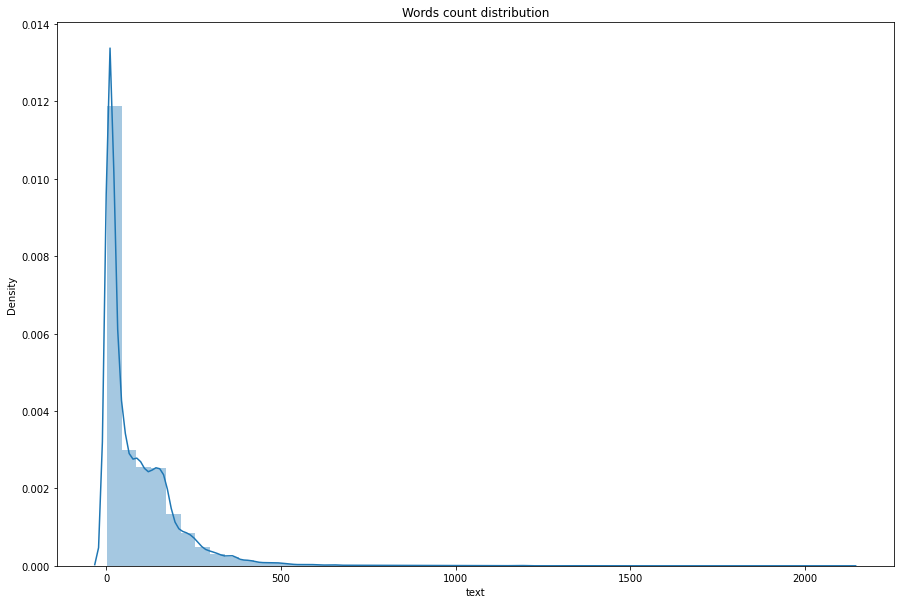

In [ ]:
#Distrbution du nombre de mots par lignes
word_count = df_train.text.apply(lambda x : len(x.split(' ')))
plt.figure(figsize=(15,10))
sns.distplot(word_count)
plt.title("Words count distribution")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_train,
                                   test_size=0.2, 
                                   random_state= 42)

#Génération de bruit pour équilibrer les labels
#X_train= X_train.groupby('labels').apply(pd.DataFrame.sample, n=3000, replace=True).reset_index(drop=True)
#X_train = X_train.sample(frac=1)

In [ ]:
y_train = X_train['labels']
X_train = X_train.drop('labels', axis=1)

y_test = X_test['labels']
X_test = X_test.drop('labels', axis=1)

In [ ]:
print('shape X_train:', X_train.shape) 
print('shape X_test:', X_test.shape) 
print('shape y_train:', y_train.shape) 
print('shape y_test:', y_test.shape)

shape X_train: (67932, 2)
shape X_test: (16984, 2)
shape y_train: (67932,)
shape y_test: (16984,)


In [ ]:
#Sauvegarde des df préparés pour future mise en production
X_train.to_csv('X_train_multimodal.csv', index=True, encoding='utf-8')
df_test.to_csv('df_test_prepared.csv', index=True, encoding='utf-8')

## Preprocessing du texte

In [ ]:
#Initialisation du module Falbert et camembert : Corpus multilingue pré-entrainé

from transformers import CamembertConfig, CamembertTokenizer, TFCamembertModel, AdamW
from transformers import BertConfig, TFBertModel, BertTokenizer, AdamW
#from transformers.modeling_utils import SequenceSummary

model_bert = 'bert-base-multilingual-cased'
model_camembert = 'camembert-base'


#config_flau = FlaubertConfig(dropout=0.2, attention_dropout=0.2)
#config_cam = CamembertConfig(dropout=0.2, attention_dropout=0.2)

tokenizer_bert = BertTokenizer.from_pretrained(model_bert, do_lowercase=False)
tokenizer_cam = CamembertTokenizer.from_pretrained(model_camembert, do_lowercase=False)

In [ ]:
def encode(sentences, tokenizer, maxlen):
    input_ids = []
    attention_masks = []

    # Pour chaque sentences...
    for sent in tqdm(sentences):
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode. / des fois j'écris en Anglais
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = maxlen,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'np',     # Return Numpy.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into arrays.
    input_ids = np.asarray(input_ids, dtype='int32')
    attention_masks = np.asarray(attention_masks, dtype='int32')

    input_ids = np.squeeze(input_ids)
    attention_masks = np.squeeze(attention_masks)
    
    return input_ids ,attention_masks

In [ ]:
MAX_LEN = 550

#Bert tokenizer
tr_input_ids_bert, tr_attention_masks_bert = encode(X_train.text.values, tokenizer_bert, maxlen=MAX_LEN)
val_input_ids_bert, val_attention_masks_bert  = encode(X_test.text.values, tokenizer_bert, maxlen=MAX_LEN)

tr_input_ids_cam, tr_attention_masks_cam = encode(X_train.text.values, tokenizer_cam, maxlen=MAX_LEN)
val_input_ids_cam, val_attention_masks_cam  = encode(X_test.text.values, tokenizer_cam, maxlen=MAX_LEN)

print('Shape pour Flaubert')
print('Train input:', tr_input_ids_bert.shape)
print('Train mask:', tr_attention_masks_bert.shape)
print('Val input:', val_input_ids_bert.shape)
print('Val mask:', val_attention_masks_bert.shape)
print()
print('Shape pour Camembert')
print('Train input:',tr_input_ids_cam.shape)
print('Train mask:',tr_attention_masks_cam.shape)
print('Val input:', val_input_ids_cam.shape)
print('Val mask:', val_attention_masks_cam.shape)

  0%|          | 0/67932 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/16984 [00:00<?, ?it/s]

  0%|          | 0/67932 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/16984 [00:00<?, ?it/s]

Shape pour Flaubert
Train input: (67932, 550)
Train mask: (67932, 550)
Val input: (16984, 550)
Val mask: (16984, 550)

Shape pour Camembert
Train input: (67932, 550)
Train mask: (67932, 550)
Val input: (16984, 550)
Val mask: (16984, 550)


## Preprocessing des images

In [ ]:
#Plot some random images
import cv2
from glob import glob
import random
def plotImages():
    i=1
    plt.figure(figsize=(15,10))
    for r in random.sample(glob(path_cwd + '/images/image_train/**'), 15):
      plt.subplot(3,5,i)
      img = cv2.imread(r)
      img = tf.reverse(img, axis=[-1])
      img = tf.image.adjust_contrast(img, 1.35)
      plt.imshow(img)
      i+=1
      plt.axis('off')

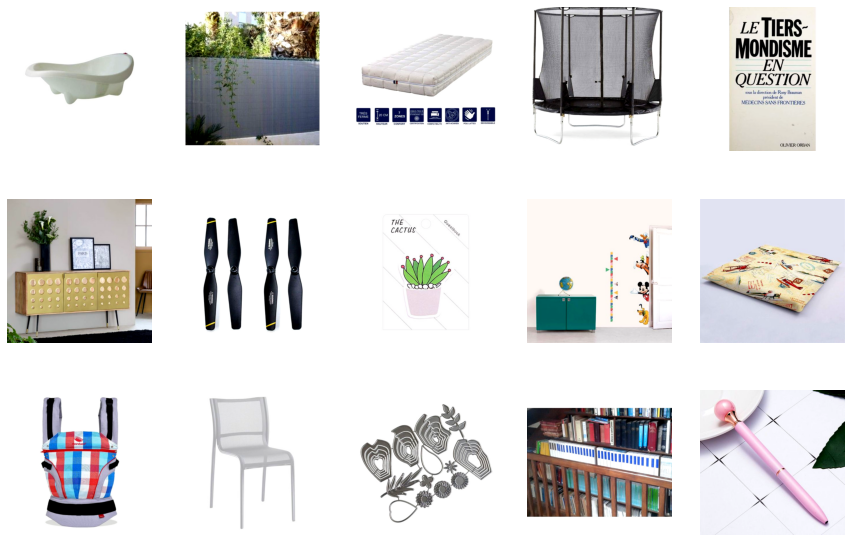

In [ ]:
plotImages()



```
#One Hot Encoding

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
```



## BERT for classification
<img src="http://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" alt="data" style="width: 1000px;">

In [ ]:
#Importation des packages pour la création du model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, Conv1D, GlobalMaxPool1D
from keras import backend as K

#Model text ML Bert
def Build_Bert(max_len=MAX_LEN):
  input_ids = Input(shape=(MAX_LEN,), name='input_ids_bert', dtype='int32')
  attention_mask = Input(shape=(MAX_LEN,), name='attention_mask_bert', dtype='int32')  

  transformer = TFBertModel.from_pretrained(model_bert)
  embedding_layer = transformer([input_ids, attention_mask])[0]
  seq_output = embedding_layer[:,0,:]

  #Freeze des layers
  for layer in transformer.layers:
    layer.trainable = True
    
  return Model(inputs=[input_ids,attention_mask], outputs=seq_output)

In [ ]:
#Model text Camembert

def Build_Camembert(max_len=MAX_LEN):
  input_ids = Input(shape=(MAX_LEN,), name='input_ids_cam', dtype='int32')
  attention_mask = Input(shape=(MAX_LEN,), name='attention_mask_cam', dtype='int32') 

  transformer = TFCamembertModel.from_pretrained(model_camembert)
  embedding_layer = transformer([input_ids, attention_mask])[0]
  seq_output = embedding_layer[:,0,:]

  #Freeze des layers
  for layer in transformer.layers:
    layer.trainable = True
    
  return Model(inputs=[input_ids,attention_mask]  , outputs=seq_output)

## Architecture globale RESNET:
____________________________________________________________________________________________________________________________
<img src="https://eenews.cdnartwhere.eu/sites/default/files/styles/inner_article/public/sites/default/files/images/resnet50_630.jpg?itok=wwfitQpt" alt="data2" align="top" style="width: 800px;">

____________________________________________________________________________________________________________________________



In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalMaxPool2D, Conv2D, GlobalAvgPool2D

#Model Image
def Build_Resnet():

  shape = (224,224,3)
  base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=shape)
  base_model.trainable = True #fine tune
  
  inputs = Input(shape=shape, name='input_im')
  resnet = base_model(inputs, training=True)
  conv2d = Conv2D(filters=768, kernel_size=3, padding='same')(resnet)

  reduce_dim= GlobalMaxPool2D(name='reduce_dim')(conv2d)

  return Model(inputs=inputs, outputs = reduce_dim)

In [ ]:
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Layer

#Création d'un ensemble: va gérer le poids de chaque modèles pur la concaténation
class LinearW(Layer):

    def __init__(self):
        super(LinearW, self).__init__()
        
    def build(self, input_shape):
        
        self.W = self.add_weight(
                    shape=(1,1,len(input_shape)),
                    initializer='uniform',
                    dtype=tf.float32,
                    trainable=True, name='weighted_layer')
        
    def call(self, inputs):

        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim

        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)

def final_model():
    model_img =  Build_Resnet()
    model_bert = Build_Bert()
    model_camembert = Build_Camembert()
    merged = LinearW()([model_img.output, model_bert.output, model_camembert.output]) # concatenation des trois models
    model_out = Dense(256, activation= 'relu', name='dense_1')(merged)
    model_out = Dropout(0.2, name='dropout_1')(model_out)
    model_out = Dense(128, activation= 'relu', name='dense_2')(model_out)
    model_out = Dropout(0.2, name='dropout_2')(model_out)
    model_out = Dense(27, activation= 'softmax', name='classifer')(model_out) 
    return Model([model_img.input, model_bert.input,  model_camembert.input], model_out) ## Final layer

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if y

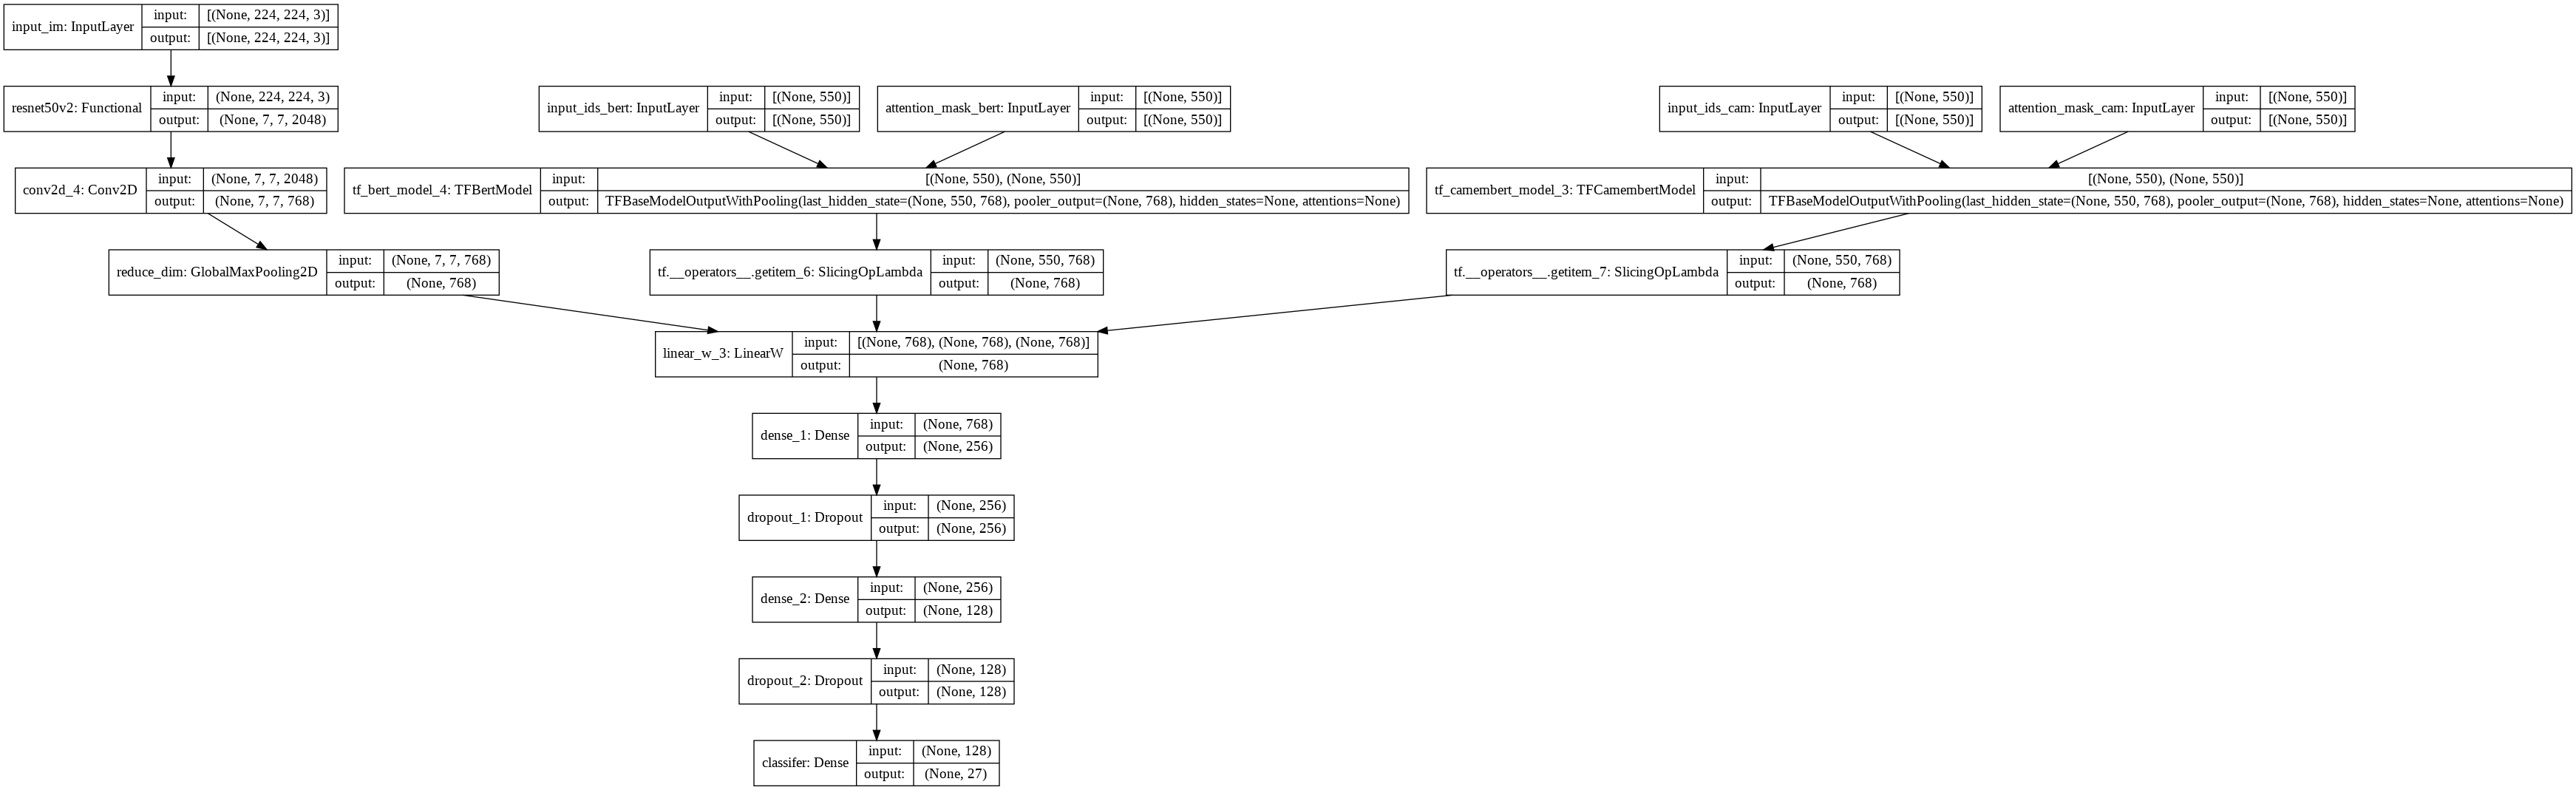

In [ ]:
from keras.utils.vis_utils import plot_model
model = final_model()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
IMG_SHAPE = 224

In [ ]:
@tf.function

#Fonction pour prprocessing des images
def scale_down(img):
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])
    img = (img / 255)
    
    return img

#Preprocessing du jeu d'entrainement
def preprocessing_train(img):
    
    #Lecture et décodage des images:
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels=3)
    
    img = tf.image.random_crop(img, size=[180, 224, 3])
    img = tf.image.adjust_contrast(img, 1.15)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_flip_up_down(img)

    #Resize
    img = scale_down(img)

    return img

In [ ]:
@tf.function
#Preprocessing du jeu de validation
def preprocessing_test(img):
    
    #Lecture et décodage des images:
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels=3)

    #Resize
    img = scale_down(img)
    
    return img

In [ ]:
#Création d'un itérateur pour le model
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
X_train_img = X_train.filename_google.values
X_test_img = X_test.filename_google.values

def make_datasets(s1, s2, s3 ,s4, s5, y, train=True):
  X1 = tf.data.Dataset.from_tensor_slices(s1)
  X2 = tf.data.Dataset.from_tensor_slices(s2)
  X3 = tf.data.Dataset.from_tensor_slices(s3)
  X4 = tf.data.Dataset.from_tensor_slices(s4)
  X5 = tf.data.Dataset.from_tensor_slices(s5)
  y = tf.data.Dataset.from_tensor_slices(y)

  if train is True:
    X = tf.data.Dataset.zip((X1, X2, X3, X4, X5))
    dataset = tf.data.Dataset.zip((X, y)) \
   .map(lambda x,y: [(preprocessing_train(x[0]), x[1],x[2],x[3],x[4]), y],  num_parallel_calls=AUTO) \
   .shuffle(5000) \
   .batch(BATCH_SIZE, drop_remainder=True) \
   .cache() \
   .prefetch(AUTO)

  else:
    X = tf.data.Dataset.zip((X1, X2, X3, X4, X5))
    dataset = tf.data.Dataset.zip((X, y)) \
    .map(lambda x,y: [(preprocessing_test(x[0]), x[1],x[2],x[3],x[4]), y],  num_parallel_calls=AUTO) \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .cache() \
    .prefetch(AUTO)
                 
  return dataset


dataset_train = make_datasets(X_train_img, 
                              tr_input_ids_bert, 
                              tr_attention_masks_bert, 
                              tr_input_ids_cam, 
                              tr_attention_masks_cam, 
                              y_train)

dataset_test = make_datasets(X_test_img, 
                             val_input_ids_bert, 
                             val_attention_masks_bert, 
                             val_input_ids_cam, 
                             val_attention_masks_cam, 
                             y_test, train=False)

print(dataset_train)
print(dataset_test)

#.map(lambda x1, x2, x3, x4, x5: [{'input_im':preprocessing_train(x1), 
#                                     'input_ids_flau':x2, 
#                                      'attention_mask_flau':x3, 
#                                      'input_ids_cam':x4, 
#                                      'attention_mask_cam':x5}], num_parallel_calls=AUTO) \

<PrefetchDataset shapes: (((64, 224, 224, 3), (64, 550), (64, 550), (64, 550), (64, 550)), (64,)), types: ((tf.float32, tf.int32, tf.int32, tf.int32, tf.int32), tf.int64)>
<PrefetchDataset shapes: (((64, 224, 224, 3), (64, 550), (64, 550), (64, 550), (64, 550)), (64,)), types: ((tf.float32, tf.int32, tf.int32, tf.int32, tf.int32), tf.int64)>


### Fonction avec générator

```
#Création d'un itérateur pour le model
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
labels = y_train.values
X_train_img = X_train.filename.values
X_test_img = X_test.filename.values
 
def train_generator():
  for s1, s2, s3, s4 ,s5, label in zip(X_train_img, tr_input_ids_flau, tr_attention_masks_flau, tr_input_ids_cam, tr_attention_masks_cam, y_train):
    yield {'input_im': s1, 'input_ids_flau': s2, 'attention_mask_flau': s3, 'input_ids_cam': s4, 'attention_mask_cam': s5}, label


def test_generator():
  for s1, s2, s3, s4 ,s5 in zip(X_test_img, val_input_ids_flau, val_attention_masks_flau, val_input_ids_cam, val_attention_masks_cam):
    yield {'input_im': s1, 'input_ids_flau': s2, 'attention_mask_flau': s3, 'input_ids_cam': s4, 'attention_mask_cam': s5}

    
dataset_train = tf.data.Dataset.from_generator(test_generator, output_types=({'input_im':tf.float32, 
                                                                              'input_ids_flau':tf.int32,
                                                                              'attention_mask_flau':tf.int32,
                                                                              'input_ids_cam':tf.int32,
                                                                              'attention_mask_cam':tf.int32 }, tf.int32))
  
    
dataset_test = tf.data.Dataset.from_generator(test_generator, output_types=({'input_im':tf.float32, 
                                                                              'input_ids_flau':tf.int32,
                                                                              'attention_mask_flau':tf.int32,
                                                                              'input_ids_cam':tf.int32,
                                                                              'attention_mask_cam':tf.int32}))
dataset_train=(dataset_train
               .shuffle(5000)
#               .map({'input_im': lambda x: preprocessing_train(x)},  num_parallel_calls=AUTO)
               .batch(BATCH_SIZE, drop_remainder=True)
               .cache()
               .prefetch(AUTO)
              )



print(dataset_train)
print(dataset_test)
```



In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


with tpu_strategy.scope():
 
  model = final_model()
  model.compile(tf.keras.optimizers.Adam(lr=5e-5), 
                  tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',  
                                factor = 0.1, 
                                patience = 2, 
                                min_delta = 0.001,
                                mode='auto', 
                                verbose=1)
  
  history = model.fit(dataset_train, 
                      validation_data=dataset_test, 
                      epochs=10, 
                      verbose=1,
                      batch_size=BATCH_SIZE, 
                      callbacks= reduce_lr)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if y

Epoch 1/10


1061/1061 [==============================] - 2256s 2s/step - loss: 1.2105 - accuracy: 0.6673 - val_loss: 0.6317 - val_accuracy: 0.8142
Epoch 2/10
1061/1061 [==============================] - 814s 767ms/step - loss: 0.5847 - accuracy: 0.8353 - val_loss: 0.5229 - val_accuracy: 0.8504
Epoch 3/10
1061/1061 [==============================] - 814s 767ms/step - loss: 0.4055 - accuracy: 0.8826 - val_loss: 0.5146 - val_accuracy: 0.8581
Epoch 4/10
1061/1061 [==============================] - 814s 767ms/step - loss: 0.2924 - accuracy: 0.9145 - val_loss: 0.5731 - val_accuracy: 0.8527
Epoch 5/10
1061/1061 [==============================] - 814s 767ms/step - loss: 0.2116 - accuracy: 0.9379 - val_loss: 0.5850 - val_accuracy: 0.8583

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 6/10
1061/1061 [==============================] - 814s 768ms/step - loss: 0.0929 - accuracy: 0.9736 - val_loss: 0.5785 - val_accuracy: 0.8762
Epoch 7/10
1061/1061 [======================

## Evaluation

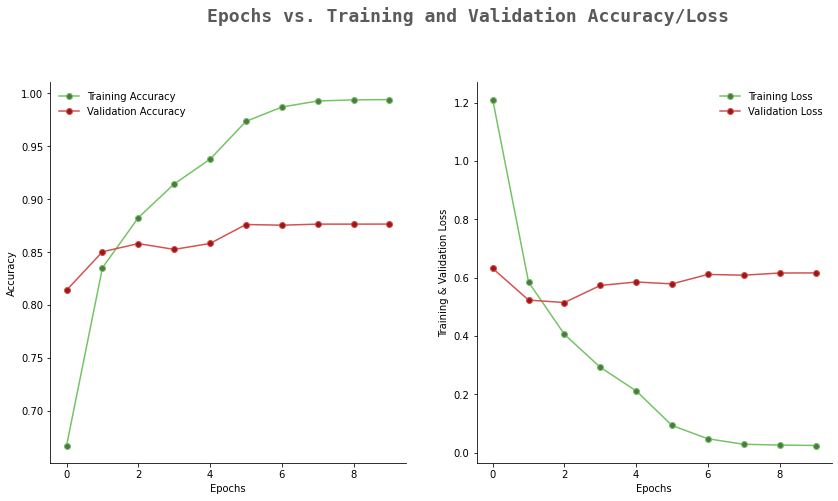

In [ ]:
#Choix des palettes de couleur
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
#Sauvegarde du model
#tf.keras.backend.clear_session()

model.save_weights('Model_Bert_Resnet.h5',  overwrite=True)
print('Saved model to disk')

#model.load_weights('Model_Bert_Resnet.h5', by_name=True)  

Saved model to disk


## Prédictions sur le set de validation

In [ ]:
#Préparation des données


input_bert_pred = val_input_ids_bert[4000:5000]
attention_masks_bert_pred = val_attention_masks_bert[4000:5000]
input_cam_pred = val_input_ids_cam[4000:5000]
attention_masks_cam_pred = val_attention_masks_cam[4000:5000]
X_test_pred= X_test.filename_google[4000:5000]
y_test_pred = y_test[4000:5000]

X_test_pred_img = []
for filepath in tqdm(X_test_pred):
  # Lecture du fichier
  img = tf.io.read_file(filepath)
  # On décode le fichier
  img = tf.image.decode_jpeg(img, channels=3)
  # Redimensionnement
  img = tf.image.resize(img, size=(224 , 224))
  img = tf.cast(img, dtype=tf.float32)
  #Standardisation
  img = (img / 255)
  X_test_pred_img.append([img])


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
X_test_pred_img = np.array(X_test_pred_img)
X_test_pred_img = X_test_pred_img[:,0,:,:]
print(X_test_pred_img.shape)

(1000, 224, 224, 3)


In [ ]:
y_pred = model.predict([X_test_pred_img, input_bert_pred, attention_masks_bert_pred, input_cam_pred, attention_masks_cam_pred])
test_pred_class = y_pred.argmax(axis = 1)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 550) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 550) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 550) dtype=int32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None, 550) dtype=int32>]


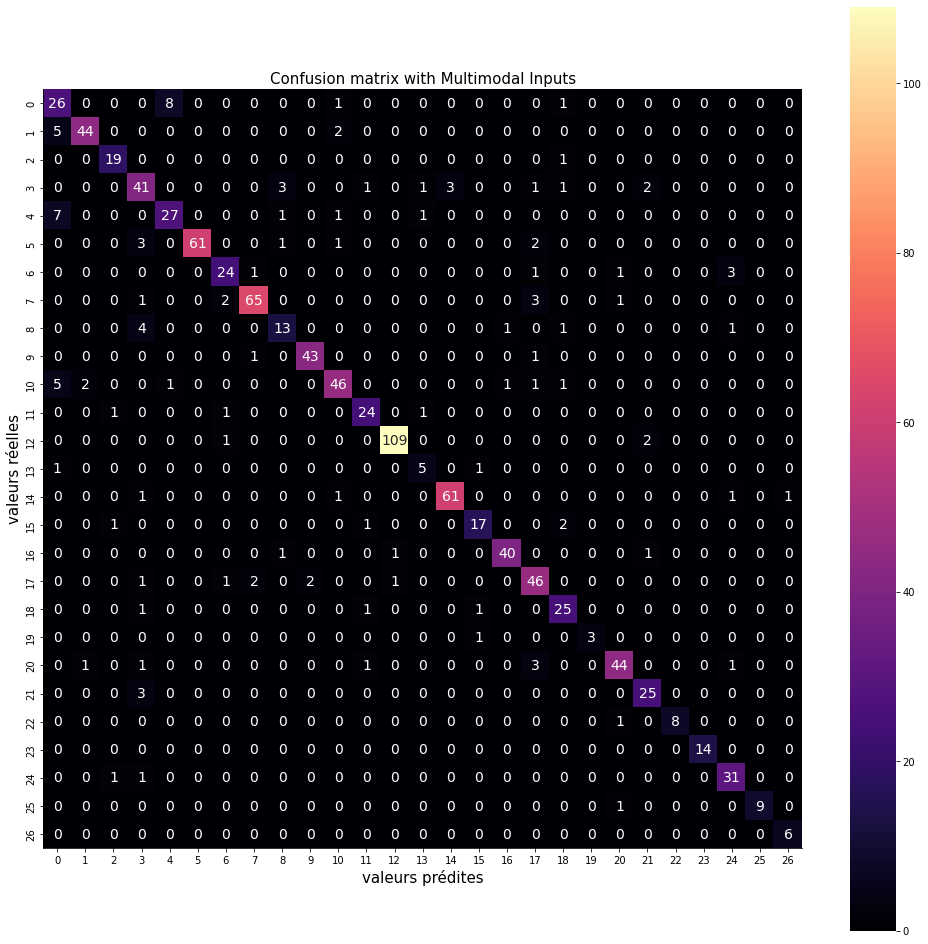

              precision    recall  f1-score   support

           0       0.72      0.59      0.65        44
           1       0.86      0.94      0.90        47
           2       0.95      0.86      0.90        22
           3       0.77      0.72      0.75        57
           4       0.73      0.75      0.74        36
           5       0.90      1.00      0.95        61
           6       0.80      0.83      0.81        29
           7       0.90      0.94      0.92        69
           8       0.65      0.68      0.67        19
           9       0.96      0.96      0.96        45
          10       0.81      0.88      0.84        52
          11       0.89      0.86      0.87        28
          12       0.97      0.98      0.98       111
          13       0.71      0.62      0.67         8
          14       0.94      0.95      0.95        64
          15       0.81      0.85      0.83        20
          16       0.93      0.95      0.94        42
          17       0.87    

In [ ]:
#Visualisation des resultats
from sklearn.metrics import classification_report, confusion_matrix
cnf_matrix = confusion_matrix(test_pred_class, y_test_pred)

#Heatmap

plt.figure(figsize=(17,17))
sns.heatmap(cnf_matrix, annot=True, cbar=True, cmap='magma', square=True, annot_kws={'fontsize': 14}, fmt='1')
plt.xlabel('valeurs prédites', fontdict={'fontsize': 15})
plt.ylabel('valeurs réelles', fontdict={'fontsize': 15})
plt.title('Confusion matrix with Multimodal Inputs', fontsize = 15)
sns.despine()
plt.show();
print(classification_report(y_test_pred, test_pred_class))

## Prédictions sur des données non labelisées 

In [ ]:
@tf.function

#Fonction pour prprocessing des images
def scale_down(img):
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])
    img = (img / 255)
    
    return img

#Preprocessing du jeu d'entrainement
def preprocessing_test(img):
    
    #Lecture et décodage des images:
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = scale_down(img)

    return img

In [ ]:
#Conformité du lien vers le bucket

X_test_img = df_test.filename_google.values
test_input_ids_bert, test_attention_masks_bert = encode(df_test.text.values, tokenizer_bert, maxlen=MAX_LEN)
test_input_ids_cam, test_attention_masks_cam = encode(df_test.text.values, tokenizer_cam, maxlen=MAX_LEN)

def make_test():
  X1 = tf.data.Dataset.from_tensor_slices(X_test_img)
  X2 = tf.data.Dataset.from_tensor_slices(test_input_ids_bert)
  X3 = tf.data.Dataset.from_tensor_slices(test_attention_masks_bert)
  X4 = tf.data.Dataset.from_tensor_slices(test_input_ids_cam)
  X5 = tf.data.Dataset.from_tensor_slices(test_attention_masks_cam)
  X = tf.data.Dataset.zip((X1, X2, X3, X4, X5)) \
  .map(lambda r,s,t,u,w:[(preprocessing_test(r), s, t, u, w)],  num_parallel_calls=AUTO) \
  .batch(1) \
  .cache() \
  .prefetch(AUTO)

  return X

zipped_input = make_test()
print(zipped_input)

<PrefetchDataset shapes: (((None, 224, 224, 3), (None, 550), (None, 550), (None, 550), (None, 550)),), types: ((tf.float32, tf.int32, tf.int32, tf.int32, tf.int32),)>


In [ ]:
y_pred = model.predict(zipped_input)
test_pred_class = y_pred.argmax(axis = 1)

In [117]:
#Tableau de correspondance des classes originales pour soumission du challenge
y_pred = pd.DataFrame(test_pred_class , columns=['pred_labels'])
y_train = pd.read_csv('y_train.csv', index_col=0)

prdtypecodes = list(y_train['prdtypecode'].unique())
labels = list(y_pred['pred_labels'].unique())

#Création des listes pour remplacement
labels = sorted(labels)
print(labels)
print(prdtypecodes)
#13812

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[10, 2280, 50, 1280, 2705, 2522, 2582, 1560, 1281, 1920, 2403, 1140, 2583, 1180, 1300, 2462, 1160, 2060, 40, 60, 1320, 1302, 2220, 2905, 2585, 1940, 1301]


In [118]:
y_pred['prdtypecode'] = y_pred['pred_labels'].replace(labels, prdtypecodes)
y_pred = y_pred.drop('pred_labels', axis=1)
y_pred

,prdtypecode
0,2403
1,1140
2,2583
3,2583
4,2522
...,...
13807,1320
13808,2403
13809,2583
13810,2582


In [119]:
y_pred.index += 84916

In [120]:
y_pred.to_csv('y_pred', index = True, header= 'True')

In [121]:
df = pd.concat([df_test,y_pred], axis=1)
df= df.dropna()
df

,text,filename_google,prdtypecode
84916,folkmanis puppets marionnette et theatre mini ...,gs://multimodal_rakuten/images/image_test/imag...,2403
84917,porte flamme gaxix flamebringer gaxix u twilig...,gs://multimodal_rakuten/images/image_test/imag...,1140
84918,pompe de filtration speck badu,gs://multimodal_rakuten/images/image_test/imag...,2583
84919,robot de piscine electrique pce robot de pisci...,gs://multimodal_rakuten/images/image_test/imag...,2583
84920,hsm destructeur securio c coupe crois e x mm,gs://multimodal_rakuten/images/image_test/imag...,2522
...,...,...,...
98723,robe de soutien de sac de soins de les suspend...,gs://multimodal_rakuten/images/image_test/imag...,1320
98724,livre de phrases francais thailandais,gs://multimodal_rakuten/images/image_test/imag...,2403
98725,tifon m de espa pompe piscine tension v monoph...,gs://multimodal_rakuten/images/image_test/imag...,2583
98726,christmas home non slip door floor mats hall r...,gs://multimodal_rakuten/images/image_test/imag...,2582


In [123]:
df['filename_google'] = df['filename_google'].apply(lambda x: x.replace('gs://multimodal_rakuten', '/content'))

In [124]:
import shutil
from glob import glob
import random

for i in df.index :
    source = df.loc[i,'filename_google']
    print('source : ', source)
    repertoire_destination = 'image_pred/' + str(df.loc[i,'prdtypecode'])
    if not os.path.exists(repertoire_destination): os.makedirs(repertoire_destination)
        
    try:
        shutil.copy2(source, repertoire_destination)
        print("File copied successfully.")
# Source = destination 
    except shutil.SameFileError:
        print("Source = destination")
# Problème de droits
    except PermissionError:
        print("Problème de droits")
# For other errors
    except:
        print("Autre erreur")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
source :  /content/images/image_test/image_1211700764_product_3384988163.jpg
File copied successfully.
source :  /content/images/image_test/image_1298921784_product_4140127389.jpg
File copied successfully.
source :  /content/images/image_test/image_1313448677_product_4197677657.jpg
File copied successfully.
source :  /content/images/image_test/image_1276328086_product_4012665302.jpg
File copied successfully.
source :  /content/images/image_test/image_1316122219_product_4200871685.jpg
File copied successfully.
source :  /content/images/image_test/image_1285965500_product_4071748475.jpg
File copied successfully.
source :  /content/images/image_test/image_545860223_product_53362121.jpg
File copied successfully.
source :  /content/images/image_test/image_1271467292_product_3977398135.jpg
File copied successfully.
source :  /content/images/image_test/image_1025671279_product_554019756.jpg
File copied successfully.

In [125]:
import cv2
def plotImages(label):
    i=1
    plt.figure(figsize=(15,10))
    for r in random.sample(glob(path_cwd + '/image_pred/'  + str(label) + '/**'), 15):
        plt.subplot(3,5,i)
        img = cv2.imread(r)
        img = tf.reverse(img, axis=[-1])
        plt.imshow(img)
        i+=1
        plt.axis('off')

## Echantillons d'images pédites sur le dataset test



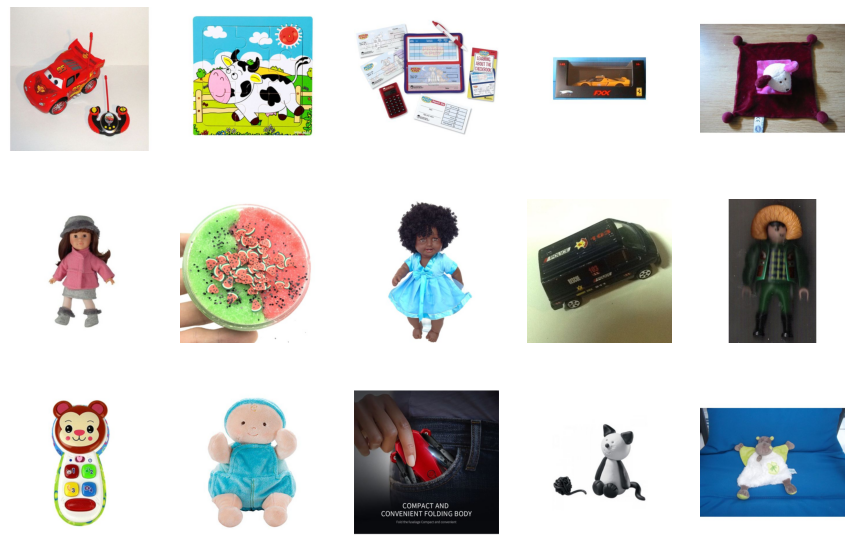

In [126]:
plotImages(1280) #Jouets enfants

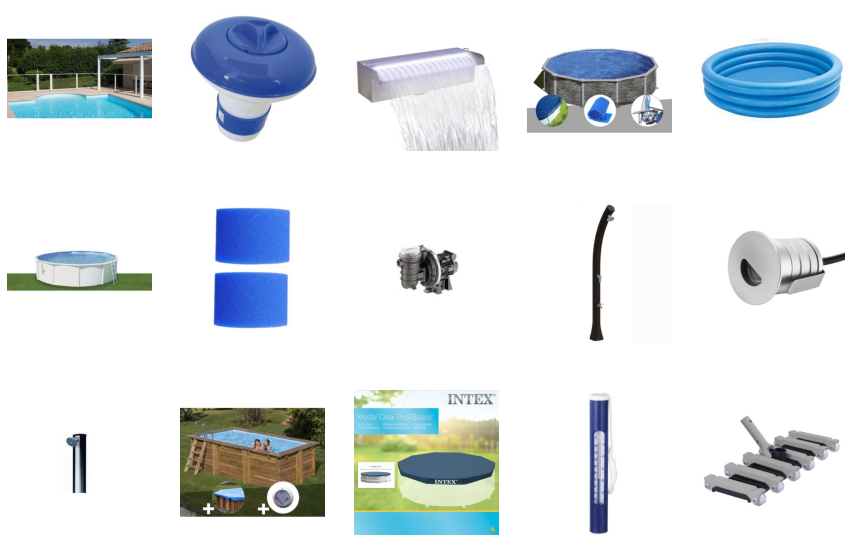

In [127]:
plotImages(2583) #Piscines

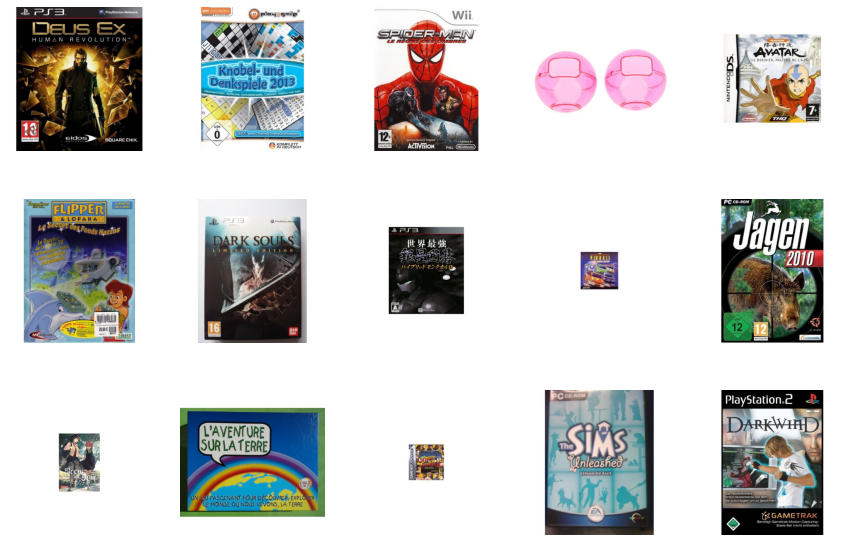

In [128]:
plotImages(40) #Jeux console et PC

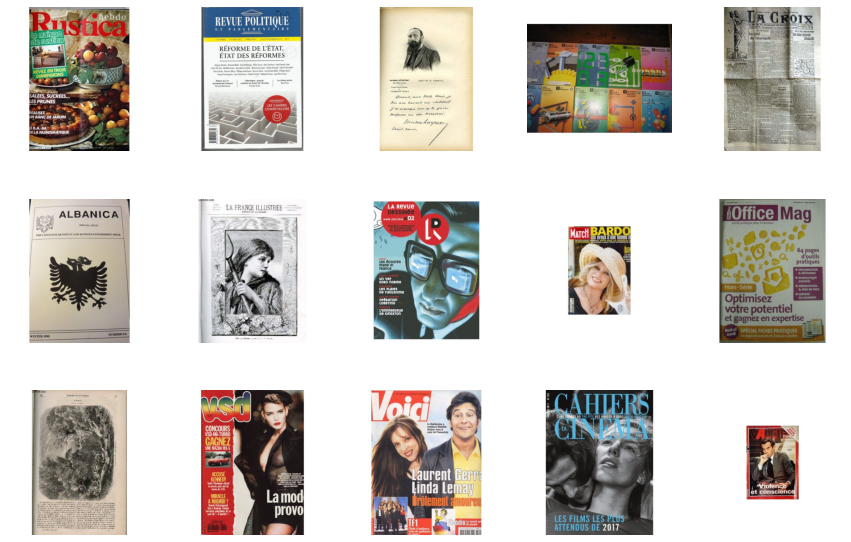

In [129]:
plotImages(2280) #Magazines et journaux

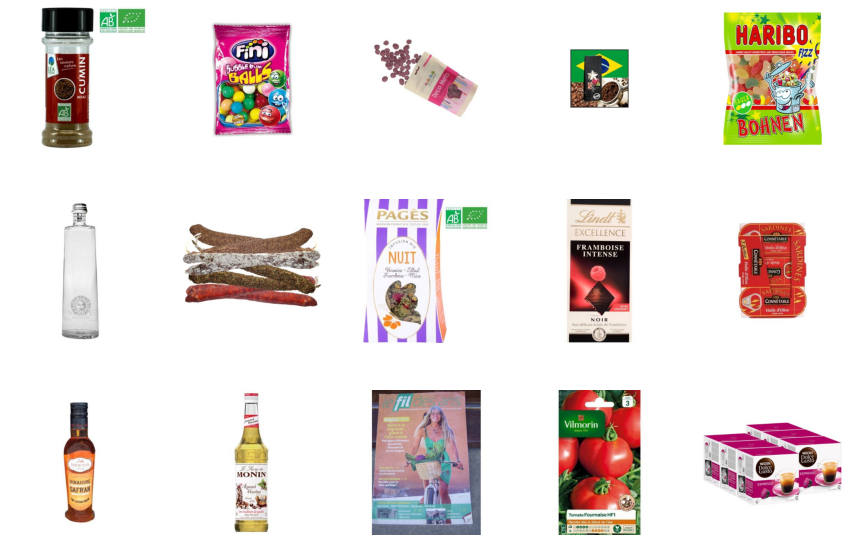

In [130]:
plotImages(1940) #Epicerie

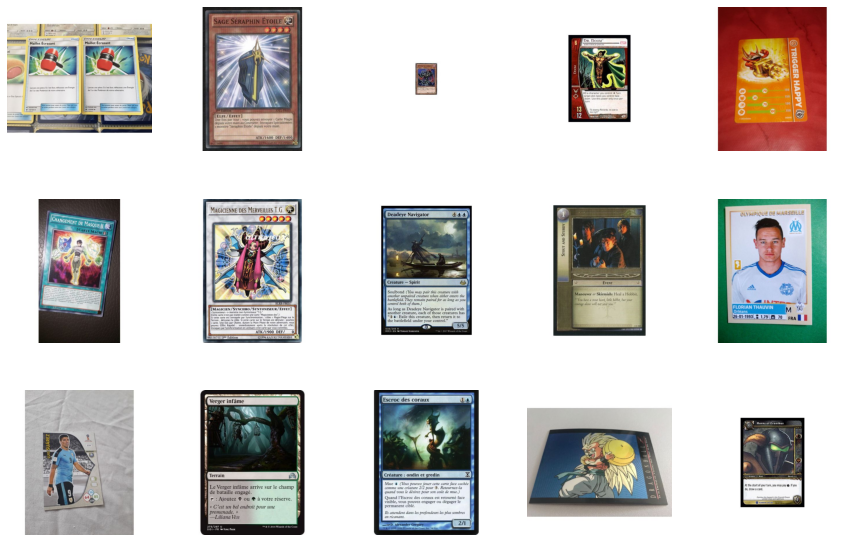

In [131]:
plotImages(1160) #Cartes collection